In [53]:
%load_ext autoreload
%autoreload 2

import os
import gym
import numpy as np
from matplotlib import pyplot as plt
import torch
from td3_torch2.agents import (
    Agent,
)  # Make sure this import matches your TD3 implementation
from envs.escape_room_continuous_space_env import EscapeRoomEnv
from tqdm.notebook import tqdm  # Using notebook version of tqdm for better integration

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
def train_td3(
    env_name="LunarLanderContinuous-v2",
    dir="tmp",
    n_games=1500,
    gamma=0.99,
    alpha=0.001,
    beta=0.001,
    fc1_dim=400,
    fc2_dim=300,
    memory_size=1000000,
    batch_size=100,
    tau=0.005,
    update_period=2,
    noise_std=0.1,
    noise_clip=0.5,
    warmup=1000,
    play=False,
    load_checkpoint=False,
    gpu_to_cpu=False,
):
    env = gym.make(env_name)
    dir_path = os.path.join(dir, env_name)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    agent = Agent(
        gamma=gamma,
        alpha=alpha,
        beta=beta,
        state_dims=env.observation_space.shape,
        action_dims=env.action_space.shape,
        max_action=env.action_space.high[0],
        min_action=env.action_space.low[0],
        fc1_dim=fc1_dim,
        fc2_dim=fc2_dim,
        memory_size=memory_size,
        batch_size=batch_size,
        tau=tau,
        update_period=update_period,
        noise_std=noise_std,
        noise_clip=noise_clip,
        warmup=warmup,
        name="TD3_" + env_name,
        ckpt_dir=dir_path,
    )

    if load_checkpoint:
        agent.load_model(gpu_to_cpu)

    score_history = []
    critic_losses = []
    actor_losses = []

    filename = f"TD3_EscapeRoom_alpha_{alpha}_beta_{beta}_{n_games}_games"
    figure_file = f"plots/{filename}.png"

    save_interval = n_games // 10
    pbar = tqdm(range(n_games), desc="Training Progress")

    critic_loss = 0
    actor_loss = 0

    for i in pbar:
        state, _ = env.reset()
        done = False
        score = 0

        while not done:
            action = agent.choose_action(state)
            next_state_info, reward, terminated, truncated, info = env.step(action)
            next_state = (
                next_state_info  # Assuming next_state_info is correctly formatted
            )
            done = terminated or truncated

            agent.store_transition(state, action, reward, next_state, done)
            learn_outputs = agent.learn()
            if learn_outputs is not None:
                if isinstance(learn_outputs[1], torch.Tensor):  # Check if the second element is a tensor
                    critic_loss = learn_outputs[1].item()
                    actor_loss = 0
                else:
                    critic_loss, actor_loss = learn_outputs
                    if actor_loss is None:
                        actor_loss = 0

            score += reward
            state = next_state

        score_history.append(score)
        critic_losses.append(critic_loss)
        actor_losses.append(actor_loss)

        avg_score = np.mean(
            score_history
        )  # Calculate average score after appending current score

        # Check if 'info' is not None before accessing 'reason'
        info_reason = info["reason"] if info is not None and "reason" in info else "N/A"

        if (
            i % save_interval == 0 or i == n_games - 1
        ):  # Save model and plot at intervals
            agent.save_model()

        pbar.set_description(
            f"Episode {i}: Score {score:.1f}, Info : {info_reason}, Average Score {avg_score:.3f}, Actor Losses {actor_losses[-1]:.3f}, Critic Losses {critic_losses[-1]:.3f}"
        )

    return score_history, critic_losses, actor_losses, figure_file

In [55]:
score_history, critic_losses, actor_losses, figure_file = train_td3()

Training Progress:   0%|          | 0/1500 [00:00<?, ?it/s]

... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


In [12]:
import torch


def plot_training_results(x, scores, critic_losses, actor_losses, figure_file):
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))

    axs[0].plot(x, scores, label="Score per Episode", color="blue")
    axs[0].set_title("Scores Over Episodes")
    axs[0].set_xlabel("Episode")
    axs[0].set_ylabel("Score")
    axs[0].legend()
    axs[0].grid(True)

    # Convert CUDA tensors to CPU tensors before plotting
    critic_losses_cpu = [
        loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss
        for loss in critic_losses
    ]
    axs[1].plot(x, critic_losses_cpu, label="Critic Loss per Episode", color="red")
    axs[1].set_title("Critic Loss Over Episodes")
    axs[1].set_xlabel("Episode")
    axs[1].set_ylabel("Loss")
    axs[1].legend()
    axs[1].grid(True)

    # Convert CUDA tensors to CPU tensors before plotting
    actor_losses_cpu = [
        loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss
        for loss in actor_losses
    ]
    axs[2].plot(x, actor_losses_cpu, label="Actor Loss per Episode", color="green")
    axs[2].set_title("Actor Loss Over Episodes")
    axs[2].set_xlabel("Episode")
    axs[2].set_ylabel("Loss")
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.savefig(figure_file)
    plt.show()

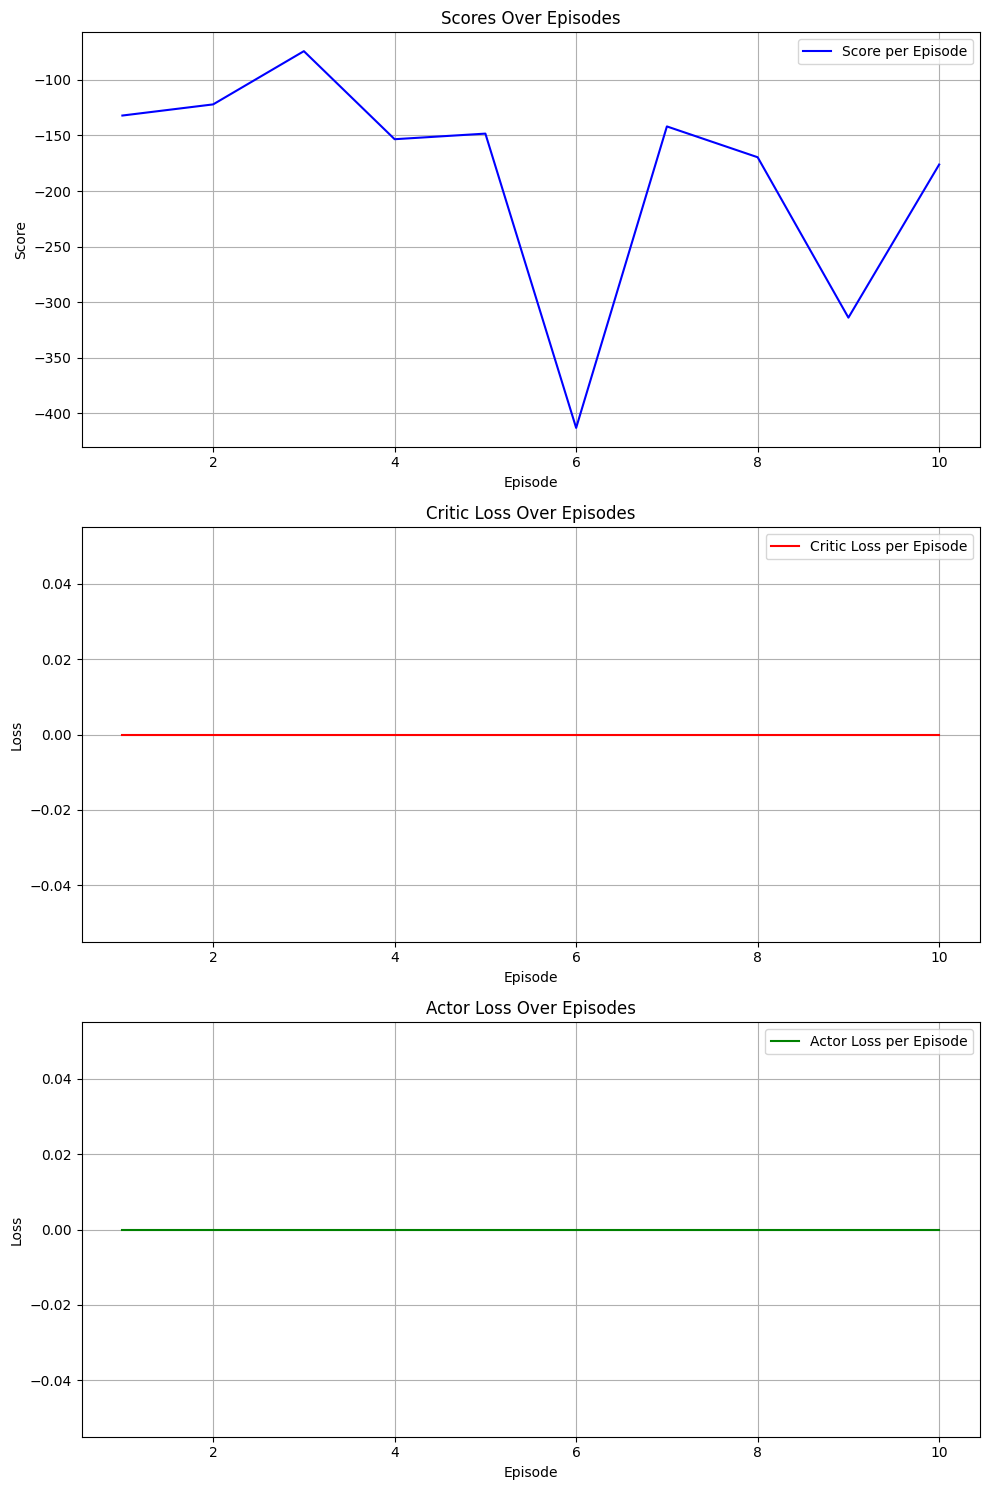

In [13]:
episodes = list(range(1, len(score_history) + 1))
plot_training_results(episodes, score_history, critic_losses, actor_losses, figure_file)

In [8]:
def load_and_simulate(env, agent, n_episodes=5, max_steps=500):
    rewards = []
    steps_per_episode = []

    for episode in range(n_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        steps = 0

        while not done:
            env.render()
            action = agent.choose_action(
                state
            )  # Assume choose_action does not require a 'noise' parameter
            state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
            steps += 1

            if steps >= max_steps:
                break

        print(f"Episode {episode + 1}: Total reward = {total_reward}, Steps = {steps}")
        rewards.append(total_reward)
        steps_per_episode.append(steps)

    env.close()  # Close the environment when done
    return rewards, steps_per_episode

In [9]:
def main():
    env_name = "LunarLanderContinuous-v2"
    dir = "tmp"
    env = gym.make(env_name, render_mode="human")
    dir_path = os.path.join(dir, env_name)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    agent = Agent(
        gamma=0.99,
        alpha=0.0001,
        beta=0.001,
        state_dims=env.observation_space.shape,
        action_dims=env.action_space.shape,
        max_action=env.action_space.high[0],
        min_action=env.action_space.low[0],
        fc1_dim=400,
        fc2_dim=300,
        memory_size=1000000,
        batch_size=64,
        tau=0.001,
        update_period=2,
        noise_std=0.1,
        noise_clip=0.5,
        warmup=1000,
        name="TD3_" + env_name,
        ckpt_dir=dir_path,
    )

    # Assuming agent.load_models is properly implemented
    agent.load_model()

    # Simulate and gather results
    n_episodes = 5
    max_steps = 1000
    rewards, steps_per_episode = load_and_simulate(env, agent, n_episodes, max_steps)


if __name__ == "__main__":
    main()

... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...


/home/nitin/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1: Total reward = 228.35515772738853, Steps = 219
Episode 2: Total reward = 45.80875584525086, Steps = 164
Episode 3: Total reward = 241.62525658063274, Steps = 190
Episode 4: Total reward = 253.62993105003162, Steps = 182
Episode 5: Total reward = 282.84958918958546, Steps = 269
